## Описание проекта

Задача  - нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Содержание

##### Часть 1. Загрузка необходимых библиотек и данных:
* [1. Загрузка данных.](#1)
* [2. Подготовка данных.](#2)

##### Часть 2. Анализ:
* [1. Анализ графиков внутри дня и вцелом.](#3)
* [2. Анализ сезонности, общего тренда.](#4)

##### Часть 3. Обучение моделей:
* [1. Подготовка признаков](#5)
* [1. Модель Linear Regression](#6)
* [1. Модель Catboost](#7)
* [2. Модель LightGBM](#8)
* [2. Модель Ramdom Forest](#9)

##### Часть 4. Анализ моделей:
* [1. Создание константной модели.](#10)
* [1. Объединение выборок.](#11)
* [2. Запуск моделей на тестовых данных.](#12)
* [3. Сравненение результатов.](#13)
* [4. Вывод.](#14)

# 1. Подготовка

In [1]:
# Подгрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

<a id='1'></a>

In [2]:
# Посмотрим на данные
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', sep=',')

# сохраним старый размер данных
old_shape = data.shape

# цикл для поиска пропусков
for data, name in zip([data], ['data']):
    print(f'Размер датафрейма {name} - {data.shape}')
    for column in (data.columns):
        data[column].value_counts()
        print("Пропусков по колонке:", column," - ", data[column]\
                                    .isna().sum(), ", доля: {:.2%}"\
                                    .format(data[column].isna().sum()/len(data[column]))) 
    display(data.info())
    display(data.head(5))
    print("------------------------------------------- ")

Размер датафрейма data - (26496, 2)
Пропусков по колонке: datetime  -  0 , доля: 0.00%
Пропусков по колонке: num_orders  -  0 , доля: 0.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


------------------------------------------- 


Вывод: данные не имеют пропусков, структурированы по дате и количеству заказов по периодам. Целевой признак - num_orders
<a id='2'></a>

In [3]:
# зададим правильный временной формат данных в колонке - время
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%dT%H:%M:%S')
# назначим эту колонку индексом
data = data.set_index('datetime')
print(data.head(3))

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28


In [4]:
# проверим на хронологичность
if data.index.is_monotonic:
    print('Данные хронологичны')
else:
    print('Данные нехронологичны')

# преобразуем в данные в формат по 1 часу
data = data.resample('10T').sum()

Данные хронологичны


In [5]:
data.head(30)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
# добавим праздники
data['holiday'] = 0
# добавим праздники
data.loc['2018-03-08 00' : '2018-03-11 23', 'holiday'] = 1
data.loc['2018-04-29 00' : '2018-05-02 23', 'holiday'] = 1
data.loc['2018-05-09 00' : '2018-05-09 23', 'holiday'] = 1
data.loc['2018-06-10 00' : '2018-06-12 23', 'holiday'] = 1

In [7]:
data['holiday'].sum()

1728

In [8]:
print(f'Размер данных после форматрирования составляет {len(data)} записей')

Размер данных после форматрирования составляет 26496 записей


# 2. Анализ

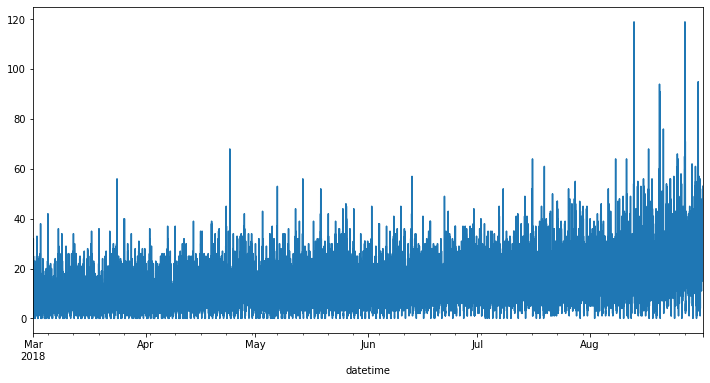

In [9]:
# посмотрим на данные
data['num_orders'].plot(figsize = (12,6))

Из графика сложно делать какие либо выводы.Оценим отдельные дни.
<a id='3'></a>

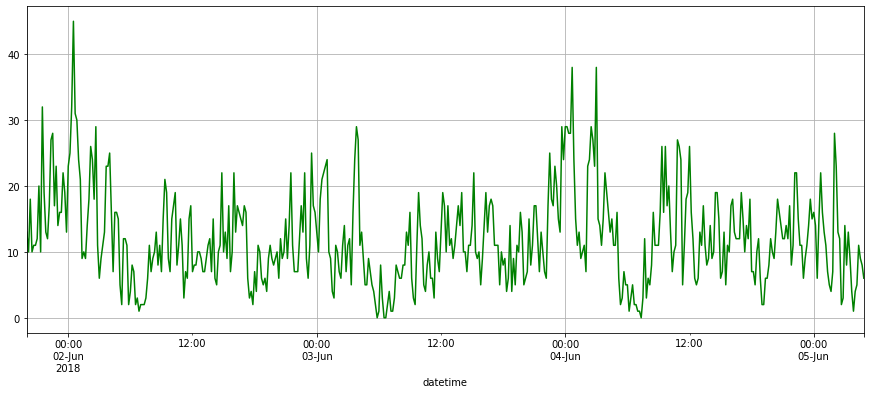

In [10]:
#Гистограм количество заказов по часам
data['2018-06-01 20':'2018-06-05 04']['num_orders'].plot(kind='line', grid = True, figsize = (15,6), color ='g')

Видны пики в позднее вечернее время, просадки в ранее утреннее время и пропорциональный рост в течении дня. 

<a id='4'></a>

(None, <matplotlib.legend.Legend at 0x20997a4da08>)

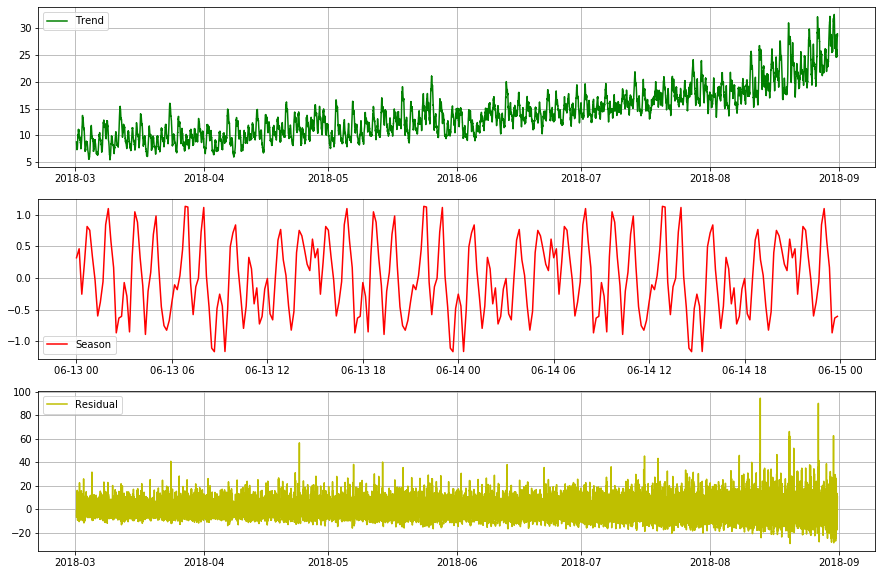

In [11]:
# оценим тренд сезонности
dec = seasonal_decompose(data['num_orders'], period=90)
fig , ax = plt.subplots(1,3, figsize=(15, 10))

plt.subplot(3,1,1)
plt.plot(dec.trend, color = 'g', label = 'Trend')
plt.legend(), plt.grid()


plt.subplot(3,1,2)
plt.plot(dec.seasonal['2018-06-13':'2018-06-14'],  label = 'Season', color = 'r')
plt.grid(), plt.legend()


plt.subplot(3,1,3)
plt.plot(dec.resid , label = 'Residual', color = 'y')
plt.grid(), plt.legend()

### Вывод
Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на ночное время, то что вполне соответсвует динамика общетсвенного транспорта по скольку он не работает в ночное время.

# 3. Обучение

In [12]:
# фунуция создание признаков
def make_features(data, max_lag):    
    # зададим час, месяц, день, день недели
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # зададим временные промежутки утренний провал, вечерний пик       
    data['late_evening'] = data['hour'].apply(lambda x : 1 if (x >= 20 and x <= 23) else 0)
    data['morning'] = data['hour'].apply(lambda x : 0 if (x >= 4 and x <= 7) else 1)
  
    # добавим отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
# применим функцию    
make_features(data,160)

# удалим пропуски
data = data.dropna()

<a id='5'></a>

In [13]:
# назначим признаки
features = data.drop('num_orders', axis=1)
target = data['num_orders']

# создадим список категориальных признаков
cat_features = ['dayofweek','hour','morning','late_evening','holiday']                                         

# разделим на признаки и целевой признак
features_train, features_valid_all, target_train, target_valid_all = train_test_split(
    features, target, test_size=0.2, shuffle=False)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_all, target_valid_all, test_size=0.5, shuffle=False)

print(f'Размер обучающей выборки равен {round(len(features_train)/len(data) * 100, 1)}%')
print(f'Размер валидационной выборки равен {round(len(features_valid)/len(data) * 100, 1)}%')
print(f'Размер тестовой выборки равен {round(len(features_test)/len(data) * 100, 1)}%')

Размер обучающей выборки равен 80.0%
Размер валидационной выборки равен 10.0%
Размер тестовой выборки равен 10.0%


## Linear regression
<a id='6'></a>

RMSE линеарной регрессии равно:  18.47


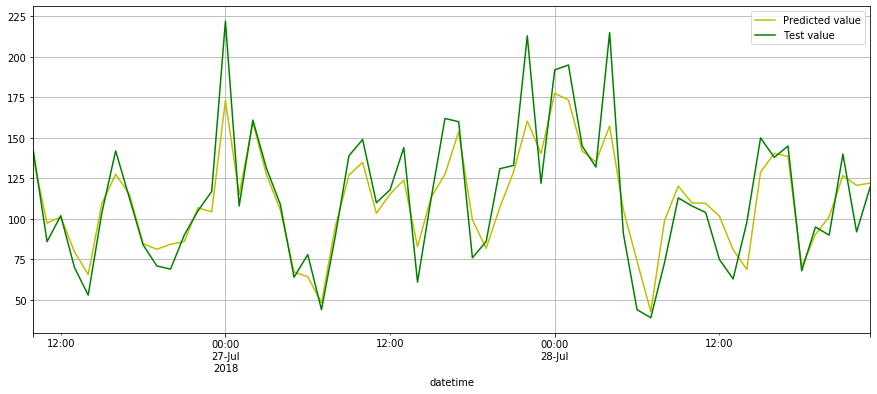

In [14]:
# назначим модель и предскажем
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
predictions_linear = model_linear.predict(features_valid)
predictions_linear_10T = pd.Series(data=predictions_linear, index=features_valid.index)
predictions_linear_1H = predictions_linear_10T.resample('1H').sum()
target_valid_1H = target_valid.resample('1H').sum()
rmse_lr = (mean_squared_error(target_valid_1H, predictions_linear_1H) ** 0.5)
print("RMSE линеарной регрессии равно: ", round(rmse_lr,2))

# сравним предсказания и таргет
pred_lr = pd.DataFrame({'Predicted value': predictions_linear_1H, 'Test value': target_valid_1H}, index=target_valid_1H.index)
pred_lr['2018-07-26' : '2018-07-28'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])


Линейная регрессия показала хороший результат на валидационной выборке, это можно объяснить линейностью наших данных.

## Catboost
<a id='7'></a>

In [15]:
%%time
# назначим модель
cat_model = CatBoostRegressor(cat_features=cat_features, verbose=0)
# обучим модель и оценим предсказания
cat_model.fit(features_train, target_train, plot=True)
# предсказания 
predict_cat = cat_model.predict(features_valid)
predictions_cat_10T = pd.Series(data=predict_cat, index=features_valid.index)
predictions_cat_1H = predictions_cat_10T.resample('1H').sum()
target_valid_1H = target_valid.resample('1H').sum()
rmse_cat = (mean_squared_error(predictions_cat_1H, target_valid_1H)) ** 0.5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 33.8 s


RMSE градиентного бустинга Catboost равняется 20.73


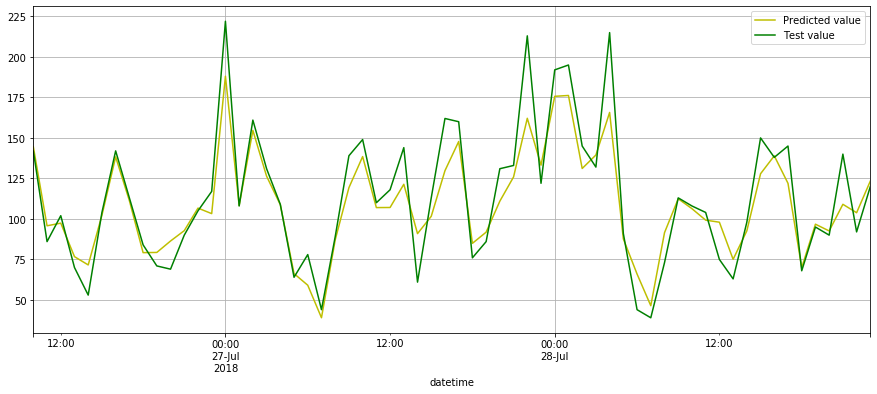

In [16]:
# оценим результаты
print(f'RMSE градиентного бустинга Catboost равняется {round(rmse_cat,2)}')
# сравним предсказания и таргет
pred_cat = pd.DataFrame({'Predicted value': predictions_cat_1H, 'Test value': target_valid_1H}, index=target_valid_1H.index)
pred_cat['2018-07-26' : '2018-07-28'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

Кэтбуст ожидаемо дал еще лучше результат за счет алгоритма работы градиентного бустинга.

### Light GBM
<a id='8'></a>

In [17]:
# зададим метрику качества для грид серча
mse_scorer = make_scorer(mean_squared_error)
# создадим копии наших выборок для их обработки в категориальный тип
lgb_features_train = features_train.copy()
lgb_features_valid = features_valid.copy()
lgb_features_test = features_test.copy()
# зададим категориальный тип для колонок с категориальными признаками
lgb_features_train[cat_features] = lgb_features_train[cat_features].astype("category")
lgb_features_valid[cat_features] = lgb_features_valid[cat_features].astype("category")
lgb_features_test[cat_features] = lgb_features_test[cat_features].astype("category")
# назначим модель
lgb_model = lgbm.LGBMRegressor(n_estimators=50)

In [18]:
# параметры для грид серча
params={
    'num_leaves':[20,33,40],
    'learning_rate':[0.05, 1, 0.5],
    'subsample':[1]
}

In [19]:
# грид серч
grid = GridSearchCV(
                    estimator=lgb_model,
                    param_grid=params,
                    scoring=mse_scorer,
                    return_train_score=True,
                    cv=5,
                    n_jobs=10
)

In [20]:
%%time
# запуск грид серча
grid.fit(lgb_features_train, target_train)

Wall time: 26.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=50, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.05, 1, 0.5],
                         'num_leaves': [20, 33, 40], 'subsample': [1]},
             pre_dispatch='2*n_jobs', refit=True, ret

RMSE градиентного бустинга Light GBM равняется 20.78
Wall time: 5.41 s


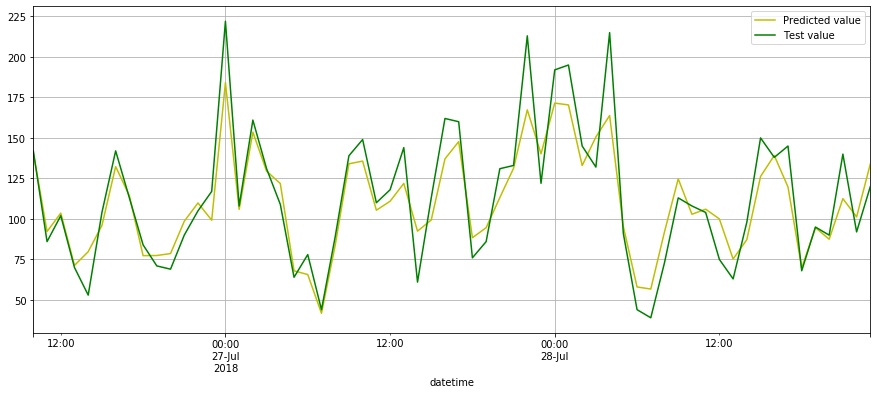

In [21]:
%%time
# сохраним лучшие результаты грид серча
cv_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score')
# сохраним модель с лучшими параметрами
best_model_lgbm = lgbm.LGBMRegressor(n_estimators=700, **cv_results['params'].iloc[0])
best_model_lgbm.fit(lgb_features_train, target_train)
# предскажем
predict_lgbm = best_model_lgbm.predict(lgb_features_valid)
predictions_lgbm_10T = pd.Series(data=predict_lgbm, index=features_valid.index)
predictions_lgbm_1H = predictions_lgbm_10T.resample('1H').sum()
target_valid_1H = target_valid.resample('1H').sum()
rmse_lgbm = (mean_squared_error(predictions_lgbm_1H, target_valid_1H)) ** 0.5
print(f'RMSE градиентного бустинга Light GBM равняется {round(rmse_lgbm,2)}')
# сравним предсказания и таргет
pred_lgbm = pd.DataFrame({'Predicted value': predictions_lgbm_1H, 'Test value': target_valid_1H}, index=target_valid_1H.index)
pred_lgbm['2018-07-26' : '2018-07-28'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

Подобранные грид серчем параметры почти догнали по точности метрики кэтбуст.

## Random forest
<a id='9'></a>

In [22]:
# параметры для грид серча
params_rf ={
    'n_estimators' :[100,200,300],
    'max_depth':[20,30,40],
    'min_samples_leaf':[2,4,6],
    'min_samples_split':[2, 4, 8]
}

In [23]:
# зададим метрику качества для грид серча
mse_scorer = make_scorer(mean_squared_error)

In [24]:
# назначим регрессор
model_rf = RandomForestRegressor(criterion='mse',max_features='sqrt',random_state=45)

In [25]:
# грид серч
grid_rf = GridSearchCV(
                    estimator=model_rf,
                    param_grid=params_rf,
                    scoring=mse_scorer,
                    return_train_score=True,
                    cv=5,
                    n_jobs=10
)

In [26]:
%%time
# запуск грид серча
grid_rf.fit(features_train, target_train)

Wall time: 25min 16s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=45,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

RMSE по регрессору Случайный лес равняется 28.118571094233047
Wall time: 30.6 s


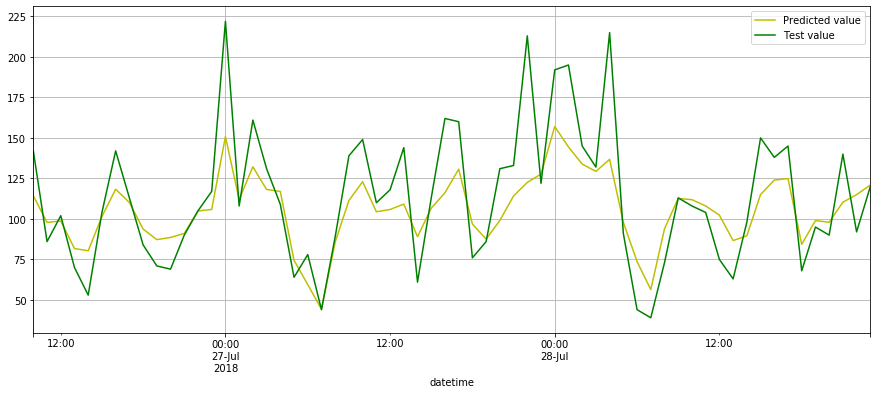

In [27]:
%%time
# сохраним лучшие результаты грид серча
cv_results_rf = pd.DataFrame(grid_rf.cv_results_).sort_values('mean_test_score')
# сохраним модель с лучшими параметрами
best_model_rf = RandomForestRegressor(criterion='mse',max_features='sqrt',random_state=45, **cv_results_rf['params'].iloc[0])
best_model_rf.fit(features_train, target_train)
# предскажем
predict_rf = best_model_rf.predict(features_valid)
predictions_rf_10T = pd.Series(data=predict_rf, index=features_valid.index)
predictions_rf_1H = predictions_rf_10T.resample('1H').sum()
target_valid_1H = target_valid.resample('1H').sum()
rmse_rf = (mean_squared_error(predictions_rf_1H, target_valid_1H)) ** 0.5
print(f'RMSE по регрессору Случайный лес равняется {rmse_rf}')
# сравним предсказания и таргет
pred_rf = pd.DataFrame({'Predicted value': predictions_rf_1H, 'Test value': target_valid_1H}, index=target_valid_1H.index)
pred_rf['2018-07-26' : '2018-07-28'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

Случайный лес по своему так же похож на бустинг, только за исключением отсутсвия фильтра по антиградиенту. Результат так же неплохой.

# 4. Тестирование

создадим константную модель предсказывающую среднее значение
<a id='10'></a>

RMSE константной модели равняется 58.697


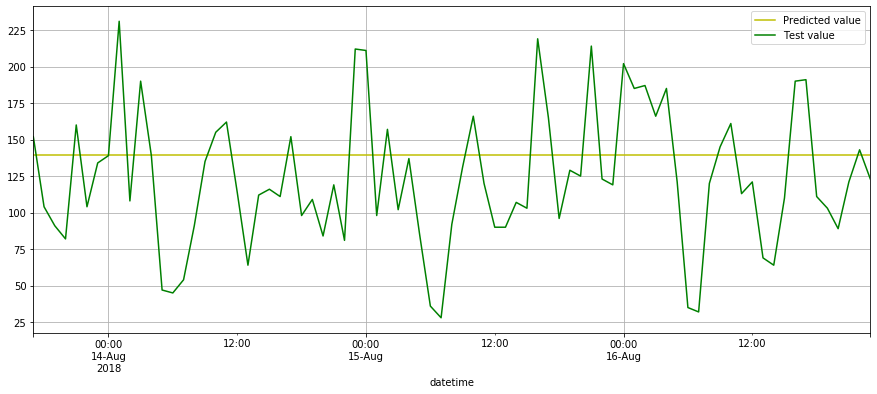

In [37]:
# создадим константную модель предсказывающую среднее значение 
mean_target_predict = [target_test.mean()] * target_test.shape[0]
# оценим метрику константной модели
predictions_const_10T = pd.Series(data=mean_target_predict, index=features_test.index)
predictions_const_1H = predictions_const_10T.resample('1H').sum()
target_test_1H = target_test.resample('1H').sum()
rmse_constant = (mean_squared_error(predictions_const_1H, target_test_1H)) ** 0.5
print(f'RMSE константной модели равняется {round(rmse_constant, 3)}')
# сравним предсказания и таргет
pred_rt = pd.DataFrame({'Predicted value': predictions_const_1H, 'Test value': target_test_1H}, index=target_test_1H.index)
pred_rt['2018-08-13' : '2018-08-16'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

Соединим наши раннее разделеные выборки трейн и валид, для того чтобы получить более последовательную общую учебную выборку по которой модели смогут более точно предсказать тестовую. Всему виной времянные ряды. Если будут пропуски, то мы скорее всего потеряем в точности.
<a id='11'></a>

In [29]:
# соединим наши выборки трейн и валид в 1 трейн для точного предсказания последовательности
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)

In [30]:
# проверим на хронологичность
if features_train.index.is_monotonic:
    print('Данные хронологичны')
else:
    print('Данные нехронологичны')

Данные хронологичны


### Линейная регрессия 

RMSE линеарной регрессии на валидационной выборке равно:  18.47
RMSE линеарной регрессии на тестовой выборке равно:  23.06


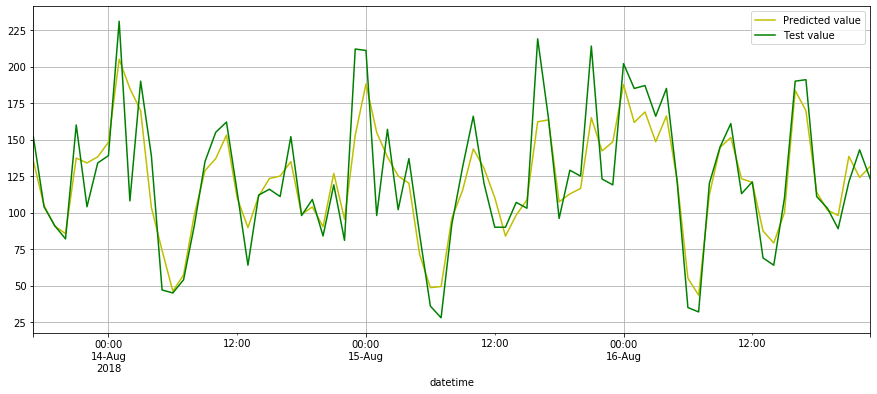

In [31]:
# обучим модель и оценим предсказания
model_linear.fit(features_train, target_train)
predictions_test_lr = model_linear.predict(features_test)
predictions_lr_10T = pd.Series(data=predictions_test_lr, index=features_test.index)
predictions_lr_1H = predictions_lr_10T.resample('1H').sum()
target_test_1H = target_test.resample('1H').sum()
rmse_lr_test = (mean_squared_error(target_test_1H, predictions_lr_1H) ** 0.5)
print("RMSE линеарной регрессии на валидационной выборке равно: ",\
                 round(rmse_lr,2))
print("RMSE линеарной регрессии на тестовой выборке равно: ",\
                 round(rmse_lr_test,2))
# сравним предсказания и таргет
pred_lr = pd.DataFrame({'Predicted value': predictions_lr_1H, 'Test value': target_test_1H}, index=target_test_1H.index)
pred_lr['2018-08-13' : '2018-08-16'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])


### Catboost
<a id='12'></a>

RMSE градиентного бустинга на валидационной выборке Catboost равняется 20.726
RMSE градиентного бустинга на тестовой выборке Catboost равняется 21.813


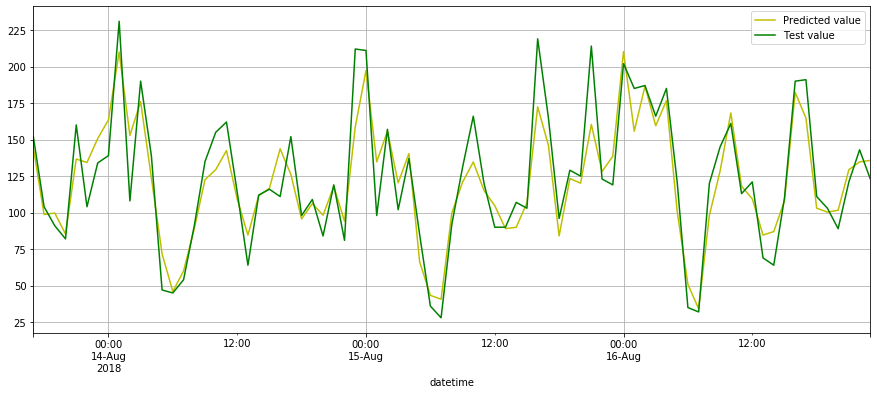

In [33]:
# назначим модель
cat_model_test = CatBoostRegressor(cat_features=cat_features, verbose=0)
# обучим модель и оценим предсказания
cat_model_test.fit(features_train, target_train)
predict_test_cat = cat_model_test.predict(features_test)
predictions_cat_10T = pd.Series(data=predict_test_cat, index=features_test.index)
predictions_cat_1H = predictions_cat_10T.resample('1H').sum()
target_test_1H = target_test.resample('1H').sum()
rmse_cat_test = (mean_squared_error(predictions_cat_1H, target_test_1H)) ** 0.5
print(f'RMSE градиентного бустинга на валидационной выборке Catboost равняется {round(rmse_cat,3)}')
print(f'RMSE градиентного бустинга на тестовой выборке Catboost равняется {round(rmse_cat_test,3)}')
# сравним предсказания и таргет
pred_cb = pd.DataFrame({'Predicted value': predictions_cat_1H, 'Test value': target_test_1H}, index=target_test_1H.index)
pred_cb['2018-08-13' : '2018-08-16'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

### LightGBM

RMSE градиентного бустинга на валидационной выборке Light GBM равняется 20.783
RMSE градиентного бустинга на тестовой выборке Light GBM равняется 21.735


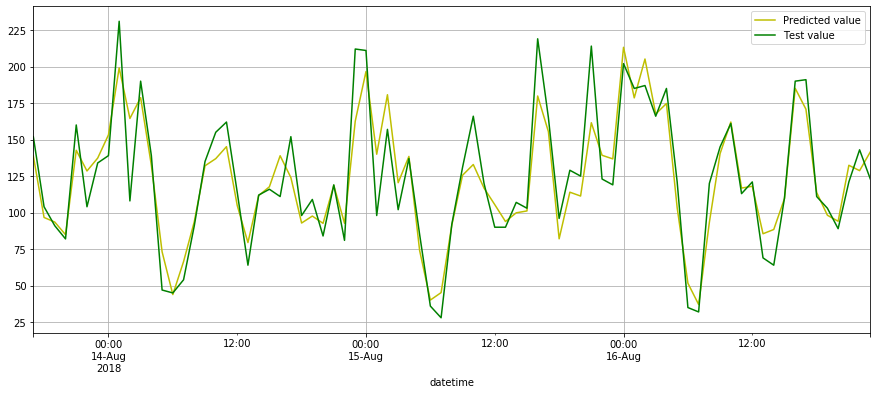

In [34]:
# создадим копии наших выборок для их обработки в категориальный тип
lgb_features_train = features_train.copy()
lgb_features_test = features_test.copy()
# подготовим признаки
lgb_features_train[cat_features] = lgb_features_train[cat_features].astype("category")
lgb_features_test[cat_features] = lgb_features_test[cat_features].astype("category")
# обучим модель и оценим предсказания
best_model_lgbm.fit(lgb_features_train, target_train)
predict_lgbm_test = best_model_lgbm.predict(lgb_features_test)
predictions_lgbm_10T = pd.Series(data=predict_lgbm_test, index=features_test.index)
predictions_lgbm_1H = predictions_lgbm_10T.resample('1H').sum()
target_test_1H = target_test.resample('1H').sum()
rmse_lgbm_test = (mean_squared_error(predictions_lgbm_1H, target_test_1H)) ** 0.5
print(f'RMSE градиентного бустинга на валидационной выборке Light GBM равняется {round(rmse_lgbm,3)}')
print(f'RMSE градиентного бустинга на тестовой выборке Light GBM равняется {round(rmse_lgbm_test,3)}')
# сравним предсказания и таргет
pred_cb = pd.DataFrame({'Predicted value': predictions_lgbm_1H, 'Test value': target_test_1H}, index=target_test_1H.index)
pred_cb['2018-08-13' : '2018-08-16'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

### Random Forest

RMSE по регрессору Случайный лес на валидационной выборке равняется 28.119
RMSE по регрессору Случайный лес на тестовой выборке равняется 34.727


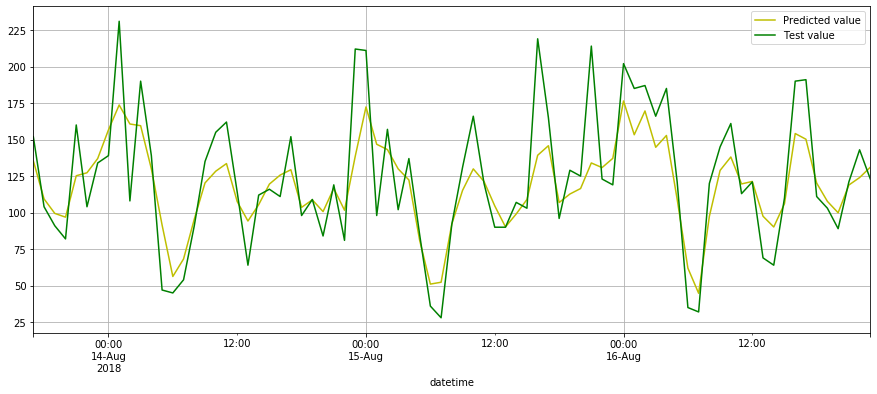

In [35]:
# предскажем
best_model_rf.fit(features_train, target_train)
predict_rf_test = best_model_rf.predict(features_test)
predictions_rf_10T = pd.Series(data=predict_rf_test, index=features_test.index)
predictions_rf_1H = predictions_rf_10T.resample('1H').sum()
target_test_1H = target_test.resample('1H').sum()
rmse_rf_test = (mean_squared_error(predictions_rf_1H, target_test_1H)) ** 0.5
print(f'RMSE по регрессору Случайный лес на валидационной выборке равняется {round(rmse_rf, 3)}')
print(f'RMSE по регрессору Случайный лес на тестовой выборке равняется {round(rmse_rf_test, 3)}')
# сравним предсказания и таргет
pred_cb = pd.DataFrame({'Predicted value': predictions_rf_1H, 'Test value': target_test_1H}, index=target_test_1H.index)
pred_cb['2018-08-13' : '2018-08-16'].plot(kind='line', grid = True, figsize = (15,6), color =['y', 'g'])

### Сравнение 
<a id='13'></a>

In [38]:
print(f'RMSE линеарной регрессии на тестовой выборке равно: {round(rmse_lr_test,2)}')
print(f'RMSE по регрессору Случайный лес на тестовой выборке равняется {round(rmse_rf_test, 2)}')
print(f'RMSE градиентного бустинга на тестовой выборке Catboost равняется {round(rmse_cat_test,2)}')
print(f'RMSE градиентного бустинга на тестовой выборке Light GBM равняется {round(rmse_lgbm_test,2)}')
print(f'RMSE константной модели равняется {round(rmse_constant, 2)}')

RMSE линеарной регрессии на тестовой выборке равно: 23.06
RMSE по регрессору Случайный лес на тестовой выборке равняется 34.73
RMSE градиентного бустинга на тестовой выборке Catboost равняется 21.81
RMSE градиентного бустинга на тестовой выборке Light GBM равняется 21.74
RMSE константной модели равняется 58.7


### Вывод 
* Имея в наличии только временной ряд данных о поездках или оплатах. 
* Имеет большое значение анализ каждого отдельного периода если мы говорим о неделе то это внутридневной разброс и особенности выходных дней. 
* Чем больше будет полезных признаков основанных на наблюдениях особенностей тем точнее модель сможет уловить какие то заивисимости и корреляции. 
* В данном примере на основе 2 обычных моделей - Линейной и Случайного леса (обе модели так или иначе имеют схожесть с бустингом) и 2 модели градиентного бустинга Catboost и LightGBM. Можно отметить следующее ---- Линейная регрессия довольно точно и быстро предсказывает необходимые значения. Случайный лес требует больше усилий по настройке и времени работы, а результат выдает очень схожий. 
* Модель бустинга Light GBM выдала наилучшее значение на тестовых данных. Остальные модели попали в допустимый диапазон RMSE < 48. 

<a id='14'></a>